In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aux_functions as aux

sns.set_theme()

In [2]:
df = pd.read_csv('../data.csv')
print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 880 
Colunas: 53


### Provando a precisão da velocidade obtida pelo FFT do tacômetro

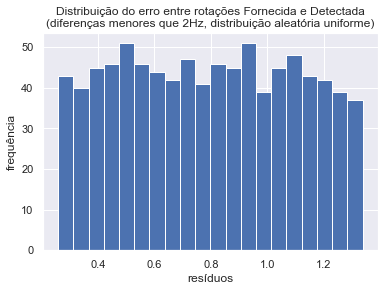

In [3]:
# distribuição do erro
plt.hist(df['rotacao']-df['fundamental'],20)
plt.title('Distribuição do erro entre rotações Fornecida e Detectada'+ 
          '\n(diferenças menores que 2Hz, distribuição aleatória uniforme)')
plt.xlabel('resíduos')
plt.ylabel('frequência')
plt.show()

# remove coluna de 'rotacao', que é redundante con 'fundamental'
df.pop('rotacao');

In [4]:
# mapeia velocidade em intervalos decimais
decimals = (pd.cut(df['fundamental'], bins=[0,15,25,35,45,55,65], labels=False)+1)*10
df.insert(3, 'fundamental_aprox', decimals)

# Organizando as features por categoria e por eixo

In [5]:
# mapeia cada categoria de feature para suas instâncias
columns = list(df.columns)
feat_type = {
    'harmonico 1':  [col for col in columns if '1h' in col],
    'harmonico 2':  [col for col in columns if '2h' in col],
    'harmonico 3':  [col for col in columns if '3h' in col],
    'entropia':   [col for col in columns if 'entr' in col],
    'curtose':    [col for col in columns if 'kurt' in col],
    'media':      [col for col in columns if 'mean' in col],
    'RMS':         [col for col in columns if 'rms' in col],
    # 'descritivos': ['defeito', severidade, 'rotacao', 'fundamental'],
}

# faz o mapeamento inverso, do nome de cada feature para a sua categoria
feat_to_type = {v[i]: k for k, v in feat_type.items() for i in range(len(v))}

# mostra cada feature
listed =[]
for k,i in feat_type.items():
    k = k +': '
    print('{:>13}'.format(k), i)
    listed.extend(i)

# mosta todas as outras colunas
print('{:>13}'.format('descritivos: '), [i for i in df.columns if i not in listed])

harmonico 1:  ['ax1_1h', 'ax2_1h', 'microfone_1h', 'rad1_1h', 'rad2_1h', 'tg1_1h', 'tg2_1h']
harmonico 2:  ['ax1_2h', 'ax2_2h', 'microfone_2h', 'rad1_2h', 'rad2_2h', 'tg1_2h', 'tg2_2h']
harmonico 3:  ['ax1_3h', 'ax2_3h', 'microfone_3h', 'rad1_3h', 'rad2_3h', 'tg1_3h', 'tg2_3h']
   entropia:  ['ax1_entr', 'ax2_entr', 'microfone_entr', 'rad1_entr', 'rad2_entr', 'tg1_entr', 'tg2_entr']
    curtose:  ['ax1_kurt', 'ax2_kurt', 'microfone_kurt', 'rad1_kurt', 'rad2_kurt', 'tg1_kurt', 'tg2_kurt']
      media:  ['ax1_mean', 'ax2_mean', 'microfone_mean', 'rad1_mean', 'rad2_mean', 'tg1_mean', 'tg2_mean']
        RMS:  ['ax1_rms', 'ax2_rms', 'microfone_rms', 'rad1_rms', 'rad2_rms', 'tg1_rms', 'tg2_rms']
descritivos:  ['defeito', 'severidade', 'fundamental', 'fundamental_aprox']


In [6]:
# mapeia cada eixo de captação para suas instâncias
eixo = {
    'axial':     [col for col in columns if 'ax' in col],
    'radial':    [col for col in columns if 'rad' in col],
    'tangente':  [col for col in columns if 'tg' in col],
    'microfone': [col for col in columns if 'mic' in col],
}

# faz o mapeamento inverso, do nome de cada feature para o seu eixo
feat_to_eixo = {v[i]: k for k, v in eixo.items() for i in range(len(v))}

# mostra cada feature
listed =[]
for k,i in eixo.items():
    k = k +': '
    print('{:>11}'.format(k), i[:7], '\n           ', i[7:], '\n')
    listed.extend(i)

    axial:  ['ax1_1h', 'ax1_2h', 'ax1_3h', 'ax1_entr', 'ax1_kurt', 'ax1_mean', 'ax1_rms'] 
            ['ax2_1h', 'ax2_2h', 'ax2_3h', 'ax2_entr', 'ax2_kurt', 'ax2_mean', 'ax2_rms'] 

   radial:  ['rad1_1h', 'rad1_2h', 'rad1_3h', 'rad1_entr', 'rad1_kurt', 'rad1_mean', 'rad1_rms'] 
            ['rad2_1h', 'rad2_2h', 'rad2_3h', 'rad2_entr', 'rad2_kurt', 'rad2_mean', 'rad2_rms'] 

 tangente:  ['tg1_1h', 'tg1_2h', 'tg1_3h', 'tg1_entr', 'tg1_kurt', 'tg1_mean', 'tg1_rms'] 
            ['tg2_1h', 'tg2_2h', 'tg2_3h', 'tg2_entr', 'tg2_kurt', 'tg2_mean', 'tg2_rms'] 

microfone:  ['microfone_1h', 'microfone_2h', 'microfone_3h', 'microfone_entr', 'microfone_kurt', 'microfone_mean', 'microfone_rms'] 
            [] 



O primeiro procedimento é separar os conjuntos.

In [7]:
# conta número de samples para cada defeito
df['defeito'].value_counts()

desbalanceamento             333
desalinhamento_vertical      301
desalinhamento_horizontal    197
normal                        49
Name: defeito, dtype: int64

Será averiguada a relvância da normalização das variáveis em relação à velocidade de rotação de cada ensaio.

In [8]:
# gera cópia profunda para alterar os valores internos sem corromper originais
df_norm = df.copy(deep=True)

# normaliza cada um por 1/fundamental
df_norm.iloc[:, 4:] = df.iloc[:, 4:].div(df['fundamental'], axis=0)

In [9]:
df.query("defeito == 'desbalanceamento' or defeito == 'normal'")

,defeito,severidade,fundamental,fundamental_aprox,ax1_1h,ax1_2h,ax1_3h,ax1_entr,ax1_kurt,ax1_mean,...,tg1_kurt,tg1_mean,tg1_rms,tg2_1h,tg2_2h,tg2_3h,tg2_entr,tg2_kurt,tg2_mean,tg2_rms
498,desbalanceamento,10.0,13.6272,10,6.966357,0.510580,5.082876,3.063727,-0.886690,0.032697,...,-0.270437,0.001106,3.332768,15.480691,7.594987,2.650111,2.635456,-0.142961,0.039913,48.052180
499,desbalanceamento,10.0,14.2284,10,5.608414,0.487584,6.771639,3.049969,-0.932425,0.031285,...,-0.163261,0.001154,3.388859,14.169379,7.455570,2.611577,2.711809,-0.293248,-0.019935,51.543861
500,desbalanceamento,10.0,15.4308,20,4.343829,2.574365,30.017157,2.884913,-0.861553,-0.009577,...,-0.056329,-0.000269,3.841905,9.420763,5.237704,1.671434,2.673544,-0.265470,0.116550,50.609899
501,desbalanceamento,10.0,16.2324,20,5.357364,2.606845,39.454727,2.780495,-0.823096,0.025364,...,-0.167401,0.002180,3.830312,11.122514,3.149082,2.196249,2.572040,-0.364828,0.081646,45.340454
502,desbalanceamento,10.0,16.8336,20,4.905962,1.965951,23.055039,2.871253,-0.867789,0.012506,...,-0.006069,0.000525,4.325995,10.391749,3.257844,1.170166,3.550595,-0.724785,-0.061868,127.442876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,normal,0.0,56.7132,60,7.739634,7.711959,6.131490,2.477337,0.048670,-0.001911,...,0.411663,0.007543,18.249959,8.387590,1.686581,3.316573,2.301806,0.186492,0.075598,34.372586
876,normal,0.0,57.5148,60,5.185984,7.770882,4.873502,2.488138,0.044559,0.005349,...,0.252392,0.000769,18.695470,5.632926,1.833460,2.565040,2.432456,0.061836,0.104439,39.727396
877,normal,0.0,58.3164,60,6.357986,6.400941,7.500388,2.498440,-0.025516,0.000983,...,0.418696,0.001562,19.275803,7.098469,1.303592,3.313748,2.685209,-0.099084,0.009523,50.332619
878,normal,0.0,59.1180,60,8.046938,7.237078,6.231257,2.485025,0.200584,0.002610,...,0.158048,-0.000626,19.976743,8.159955,2.185100,2.184384,2.797251,-0.587838,0.006272,58.233539


In [10]:
# separa cada tipo de defeito em um dataframe específico
df_desbal      =      df.query("defeito == 'desbalanceamento' or defeito == 'normal'")
df_des_ve      =      df.query("defeito == 'desalinhamento_vertical' or defeito == 'normal'")
df_des_ho      =      df.query("defeito == 'desalinhamento_horizontal' or defeito == 'normal'")

# cria dicionário que aponta o nome do defeito para o seu DataFrame
fault_to_df = {
    'desbalanceamento'         :   df_desbal,
    'desalinhamento_vertical'  :   df_des_ve,
    'desalinhamento_horizontal':   df_des_ho,
}


# repete as operações para df normalizado
df_desbal_norm = df_norm.query("defeito == 'desbalanceamento' or defeito == 'normal'")
df_des_ve_norm = df_norm.query("defeito == 'desalinhamento_vertical' or defeito == 'normal'")
df_des_ho_norm = df_norm.query("defeito == 'desalinhamento_horizontal' or defeito == 'normal'")

fault_to_normalized_df = {
    'desbalanceamento'         :   df_desbal_norm,
    'desalinhamento_vertical'  :   df_des_ve_norm,
    'desalinhamento_horizontal':   df_des_ho_norm,
}

In [11]:
# descarta a coluna 'defeito' de cada df, pois é informação redundante
for _, dfram in fault_to_df.items():
    dfram.pop('defeito')
for _, dfram in fault_to_normalized_df.items():
    dfram.pop('defeito')
    
fault_to_df['desalinhamento_vertical'].head()

,severidade,fundamental,fundamental_aprox,ax1_1h,ax1_2h,ax1_3h,ax1_entr,ax1_kurt,ax1_mean,ax1_rms,...,tg1_kurt,tg1_mean,tg1_rms,tg2_1h,tg2_2h,tg2_3h,tg2_entr,tg2_kurt,tg2_mean,tg2_rms
197,0.51,12.2244,10,8.228942,2.150474,25.329836,3.191155,-0.182071,0.019604,101.629597,...,0.368562,0.000494,4.378859,7.879026,3.827370,2.417059,2.877889,-0.431925,-0.020623,62.391259
198,0.51,12.8256,10,6.752435,2.502239,59.862730,3.205999,-0.758274,0.028971,100.445209,...,0.079796,-0.000926,4.102786,9.237435,6.823298,3.227939,2.889004,0.093143,0.324467,66.245670
199,0.51,14.6292,10,6.278360,15.256090,7.419035,3.122335,-0.806158,0.016546,91.406244,...,0.063823,0.000088,4.569676,7.627976,6.125975,3.304820,3.184046,-0.118386,-0.033993,88.370957
200,0.51,15.8316,20,5.238940,44.591728,5.590665,2.922372,-0.894518,-0.002385,74.974579,...,0.179338,0.000210,4.873681,5.295559,5.760335,3.089896,2.881914,-0.441469,-0.067903,62.329029
201,0.51,16.6332,20,8.220010,36.119777,5.176576,3.051603,-0.920649,0.014230,85.365270,...,0.028152,0.001217,5.134454,5.917923,5.214204,2.728189,3.529761,-0.933410,0.165706,125.096834


# Análise de correlação

## Desbalanceamento

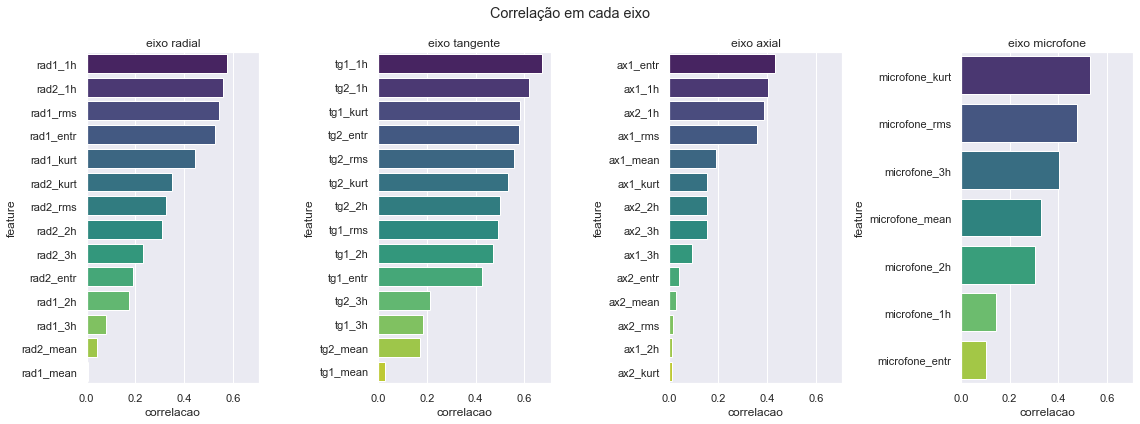

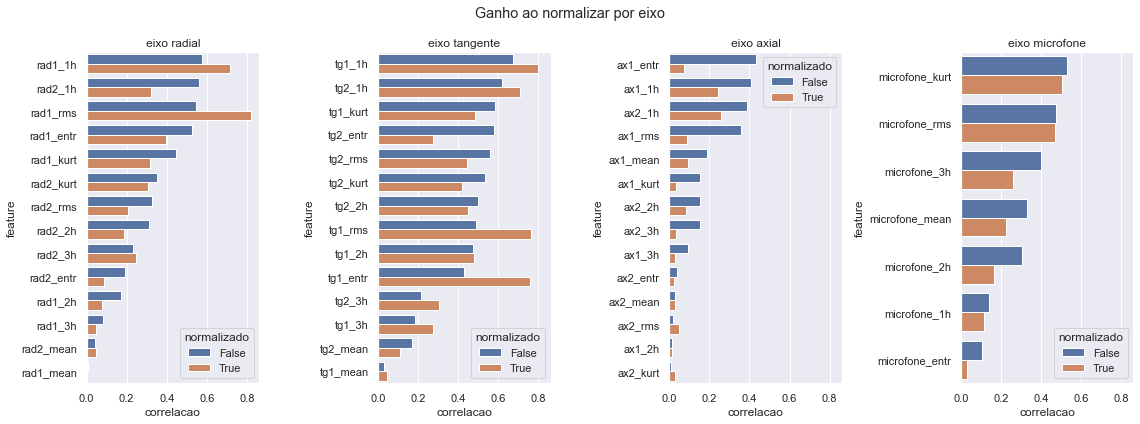

In [12]:
corr_df = aux.gera_corr_df('desbalanceamento', df_desbal, df_desbal_norm, feat_to_eixo, feat_to_type)

aux.plot_correlations(corr_df)

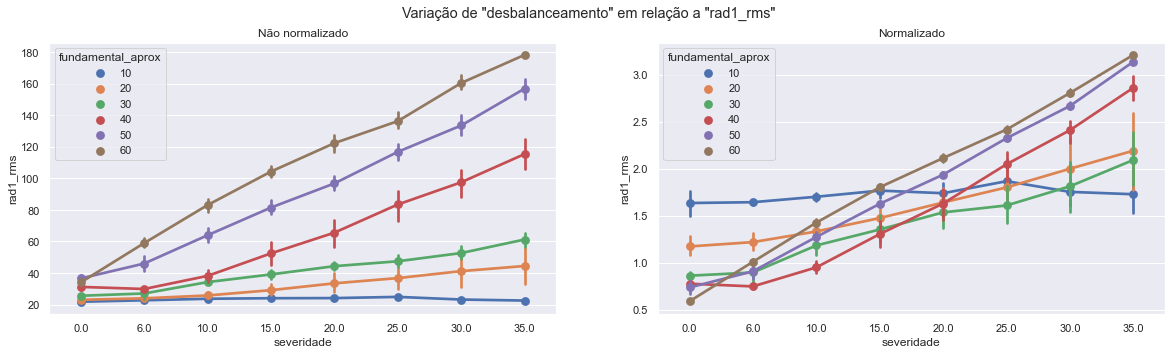

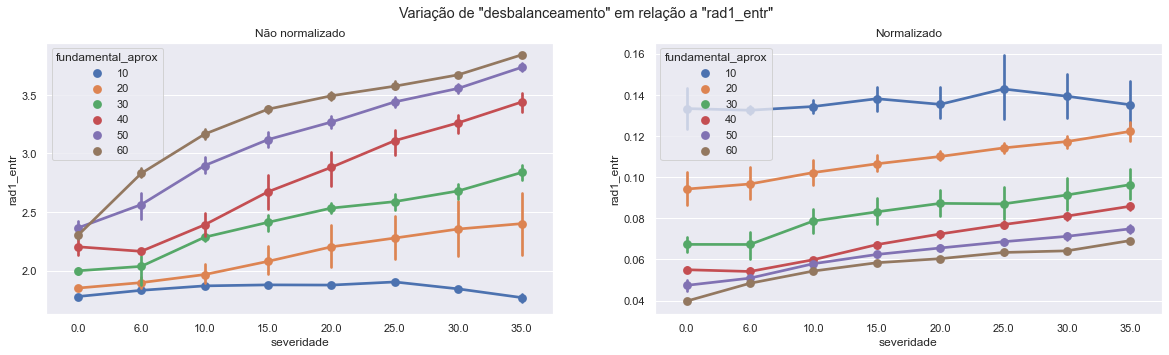

In [13]:
aux.plot_detailed_comparisson('rad1_rms', 'desbalanceamento', df_desbal, df_desbal_norm)
aux.plot_detailed_comparisson('rad1_entr', 'desbalanceamento', df_desbal, df_desbal_norm)

## Desalinhamento vertical

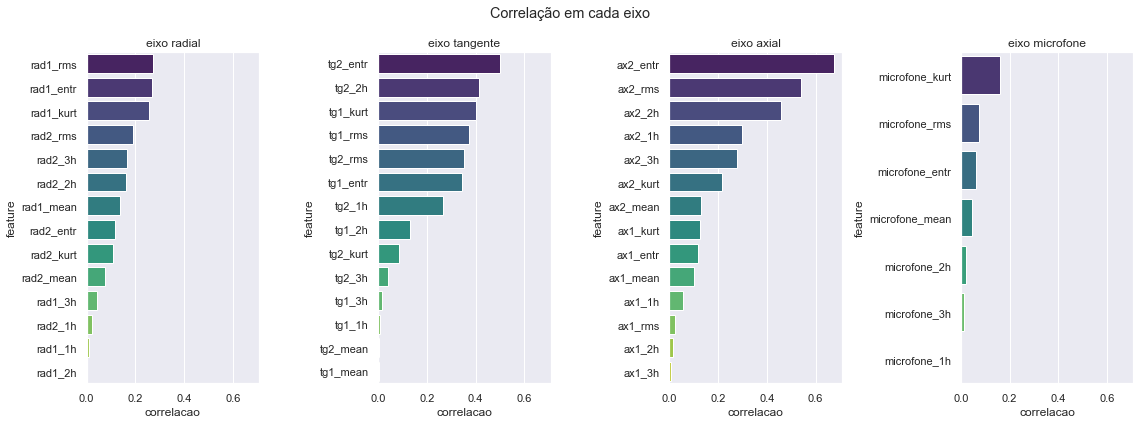

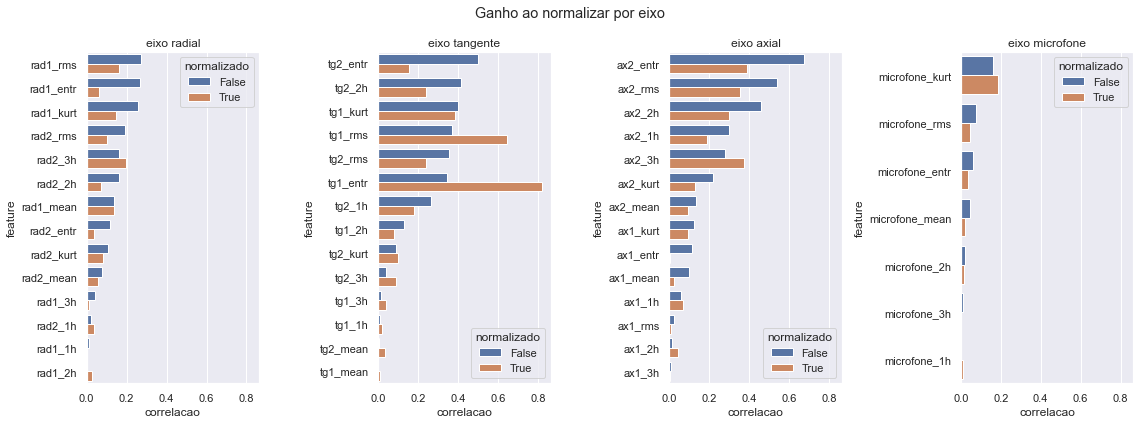

In [14]:
corr_df = aux.gera_corr_df('desalinhamento_vertical', df_des_ve, df_des_ve_norm, feat_to_eixo, feat_to_type)

aux.plot_correlations(corr_df)

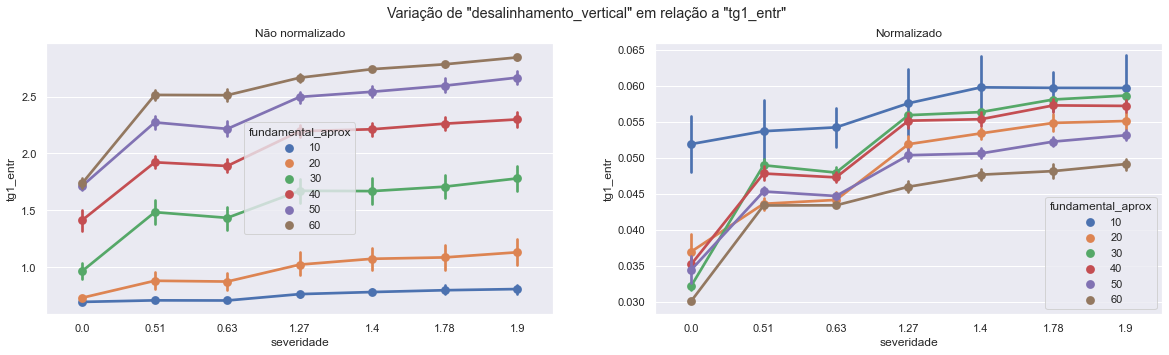

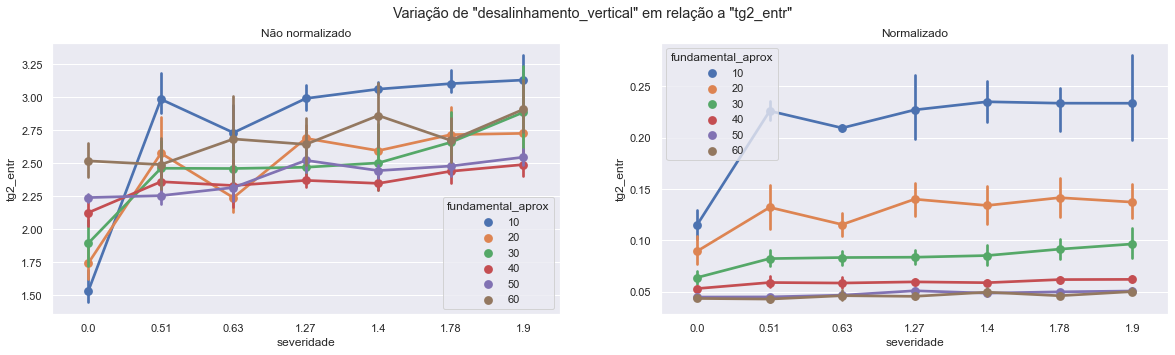

In [15]:
aux.plot_detailed_comparisson('tg1_entr', 'desalinhamento_vertical', df_des_ve, df_des_ve_norm)
aux.plot_detailed_comparisson('tg2_entr', 'desalinhamento_vertical', df_des_ve, df_des_ve_norm)

## Desalinhamento horizontal

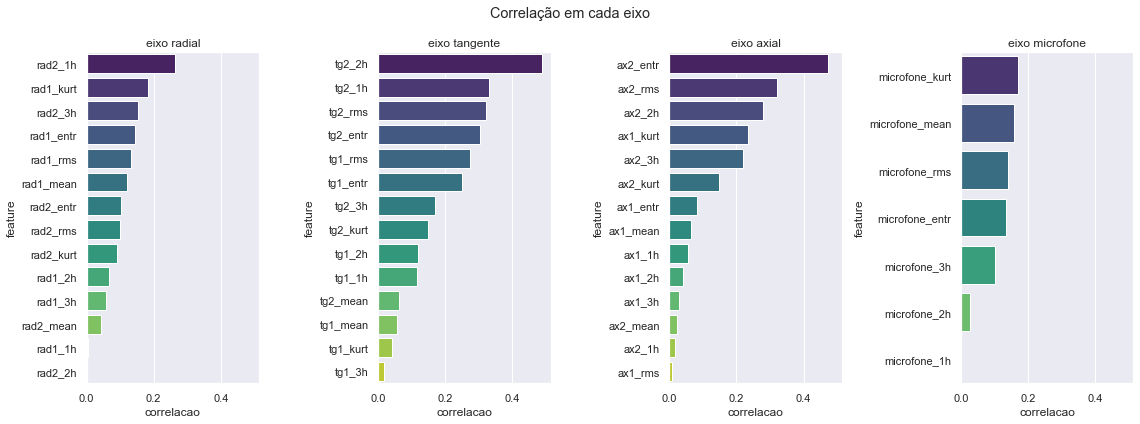

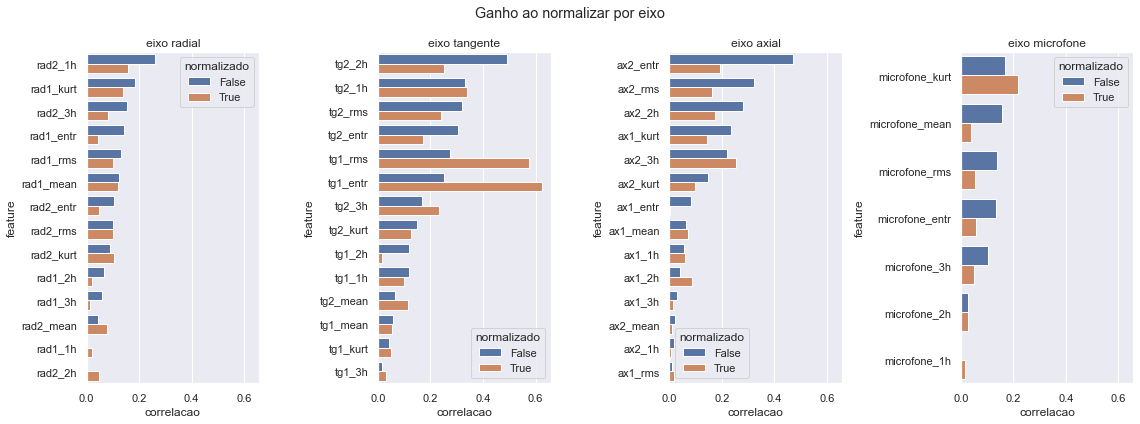

In [16]:
corr_df = aux.gera_corr_df('desalinhamento_horizontal', df_des_ho, df_des_ho_norm, feat_to_eixo, feat_to_type)

aux.plot_correlations(corr_df)

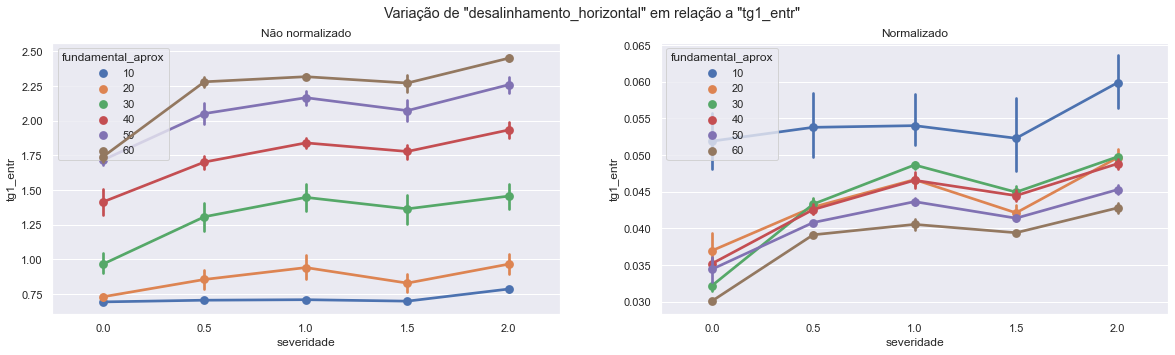

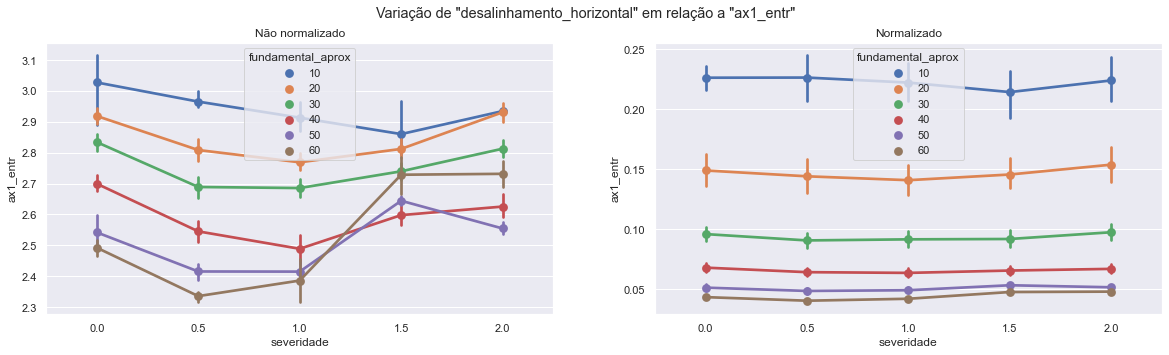

In [17]:
aux.plot_detailed_comparisson('tg1_entr', 'desalinhamento_horizontal', df_des_ho, df_des_ho_norm)
aux.plot_detailed_comparisson('ax1_entr', 'desalinhamento_horizontal', df_des_ho, df_des_ho_norm)

## Mudaças na correlação após normalização

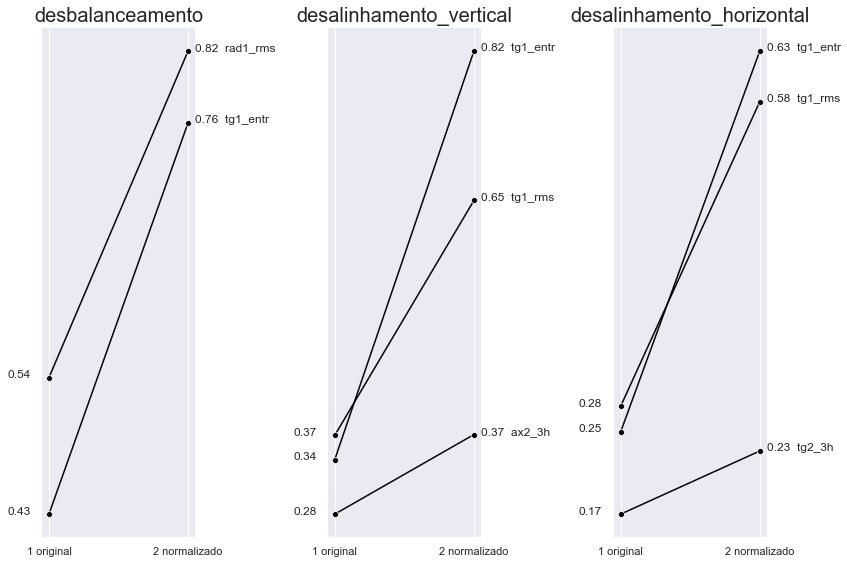

In [18]:
# plota maiores crescimentos 
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

aux.plot_change_correlation('desbalanceamento',          df_desbal, df_desbal_norm, ax=ax[0], cut=2)
aux.plot_change_correlation('desalinhamento_vertical',   df_des_ve, df_des_ve_norm, ax=ax[1])
aux.plot_change_correlation('desalinhamento_horizontal', df_des_ho, df_des_ho_norm, ax=ax[2])

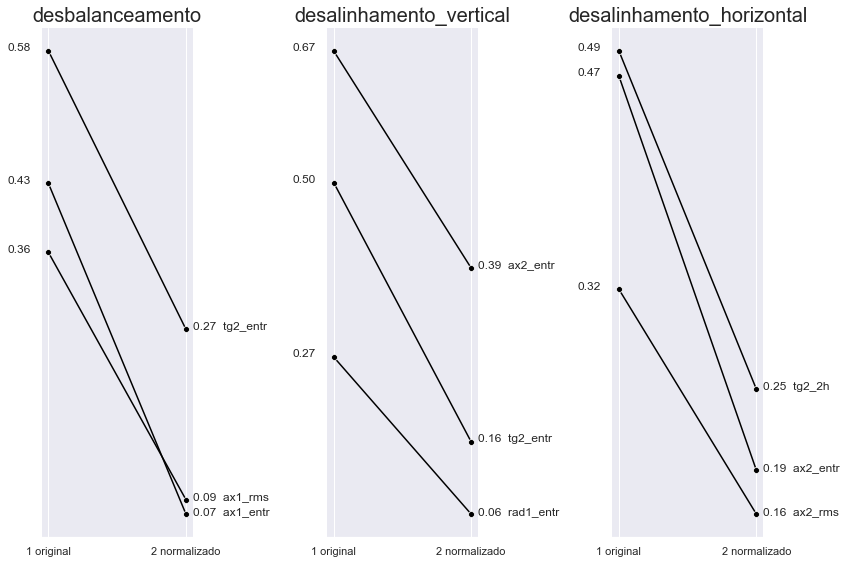

In [19]:
# plota maiores decrescimentos
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

aux.plot_change_correlation('desbalanceamento',          df_desbal, df_desbal_norm, decrescente=True, ax=ax[0])
aux.plot_change_correlation('desalinhamento_vertical',   df_des_ve, df_des_ve_norm, decrescente=True, ax=ax[1])
aux.plot_change_correlation('desalinhamento_horizontal', df_des_ho, df_des_ho_norm, decrescente=True, ax=ax[2])